In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [2]:
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [3]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, ndf=64, nc=3):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1)




In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 128
lr = 0.0002
beta1 = 0.5
epochs = 50
latent_dim = 100
image_size = 64

# Create directories for real and fake images
real_images_dir = Path("Images/Real")
fake_images_dir = Path("Images/Fake")
real_images_dir.mkdir(parents=True, exist_ok=True)
fake_images_dir.mkdir(parents=True, exist_ok=True)

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Define Generator and Discriminator architectures
# Make sure to replace these with your DCGAN Generator and Discriminator
G = Generator().to(device)
D = Discriminator().to(device)


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Initialize weights
G.apply(weights_init)
D.apply(weights_init)

# Optimizers
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()

# Training loop
best_images = []
best_scores = []

for epoch in range(epochs):
    for i, (batch_data, _) in enumerate(train_loader):
        real_data = batch_data.to(device)
        real_data_size = real_data.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()

        real_data_label = torch.full((real_data_size,), 1.0, device=device)
        real_data_output = D(real_data).view(-1)
        D_real_loss = criterion(real_data_output, real_data_label)

        noise = torch.randn(real_data_size, latent_dim, 1, 1, device=device)
        fake_data = G(noise)
        fake_data_label = torch.full((real_data_size,), 0.0, device=device)
        fake_data_output = D(fake_data.detach()).view(-1)
        D_fake_loss = criterion(fake_data_output, fake_data_label)

        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        fake_data_label.fill_(1.0)
        fake_data_output = D(fake_data).view(-1)
        G_loss = criterion(fake_data_output, fake_data_label)
        G_loss.backward()
        optimizer_G.step()

        # Generate fake data and save images
    with torch.no_grad():
        fixed_noise = torch.randn(real_data_size, latent_dim, 1, 1, device=device)
        generated_images = G(fixed_noise).detach().cpu()
        img_scores = D(generated_images.to(device)).detach().cpu().numpy()
        

            # Update the best images list
        for img, score in zip(generated_images, img_scores):
            if len(best_images) < 10:
                best_images.append(img)
                best_scores.append(score)
            else:
                min_index = best_scores.index(min(best_scores))
                if score > best_scores[min_index]:
                    best_images[min_index] = img
                    best_scores[min_index] = score

        # Save real and generated images for the current epoch
    if epoch == 49:
        for idx, img in enumerate(real_data.cpu()):
            vutils.save_image(img, real_images_dir/f"real_image{epoch}_{idx}.png", normalize=True)
        for idx, img in enumerate(generated_images.cpu()):
            vutils.save_image(img, fake_images_dir/f"fake_image{epoch}_{idx}.png", normalize=True)
            
            

        #for i in range(10):
          #  vutils.save_image(real_data[i].unsqueeze(0).cpu(), real_images_dir / f"real_image{epoch}_{i}.png", normalize=True)
          #  vutils.save_image(generated_images[i].unsqueeze(0).cpu(), fake_images_dir / f"fake_image{epoch}_{i}.png", normalize=True)
        
    #if epoch == 49:
    #    vutils.save_image(batch_data[:10].cpu(), real_images_dir / f"image{epoch}.png", nrow=10, normalize=True)
     #   vutils.save_image(generated_images[:10].cpu(), fake_images_dir / f"image{epoch}.png", nrow=10, normalize=True)

    print(f"Epoch [{epoch+1}/{epochs}] | D_loss: {D_loss.item():.4f} | G_loss: {G_loss.item():.4f}")

# Save the 10 best generated images
#best_images_grid = vutils.make_grid([img.unsqueeze(0) for img in best_images], padding=2, normalize=True, nrow=10)
#vutils.save_image(best_images_grid.cpu(), "Images/dcgan_best10_cifar10.png")


Files already downloaded and verified
Epoch [1/50] | D_loss: 0.2866 | G_loss: 5.5680
Epoch [2/50] | D_loss: 0.5929 | G_loss: 4.8050
Epoch [3/50] | D_loss: 1.2765 | G_loss: 5.1842
Epoch [4/50] | D_loss: 0.9723 | G_loss: 6.3234
Epoch [5/50] | D_loss: 0.4680 | G_loss: 2.5762
Epoch [6/50] | D_loss: 0.7322 | G_loss: 2.2167
Epoch [7/50] | D_loss: 1.3075 | G_loss: 1.4679
Epoch [8/50] | D_loss: 0.6056 | G_loss: 2.8740
Epoch [9/50] | D_loss: 0.5139 | G_loss: 2.4018
Epoch [10/50] | D_loss: 0.9041 | G_loss: 5.1141
Epoch [11/50] | D_loss: 1.3018 | G_loss: 7.0371
Epoch [12/50] | D_loss: 0.8790 | G_loss: 2.1481
Epoch [13/50] | D_loss: 0.0583 | G_loss: 4.2395
Epoch [14/50] | D_loss: 1.0780 | G_loss: 1.1519
Epoch [15/50] | D_loss: 1.0409 | G_loss: 1.4280
Epoch [16/50] | D_loss: 0.9192 | G_loss: 1.6145
Epoch [17/50] | D_loss: 0.9609 | G_loss: 1.4714
Epoch [18/50] | D_loss: 0.0440 | G_loss: 5.8072
Epoch [19/50] | D_loss: 0.4847 | G_loss: 2.5681
Epoch [20/50] | D_loss: 1.1151 | G_loss: 1.5826
Epoch [21/5

In [5]:
#import math

# Compute the number of images per row
#num_images = len(best_images)
#image_size = best_images[0].shape[-2]  # assuming all images have the same size
#padding = 2
#nrow = int(math.sqrt(num_images))  # use a square grid
#while (nrow + 1) * image_size + nrow * padding <= 800:  # increase number of rows as long as it fits in 800 pixels width
#    nrow += 1
#
# Create the grid of images
#best_images_grid = vutils.make_grid(best_images, padding=padding, normalize=True, nrow=nrow)
#vutils.save_image(best_images_grid.cpu(), "Images/dcgan_best10_cifar10.png")

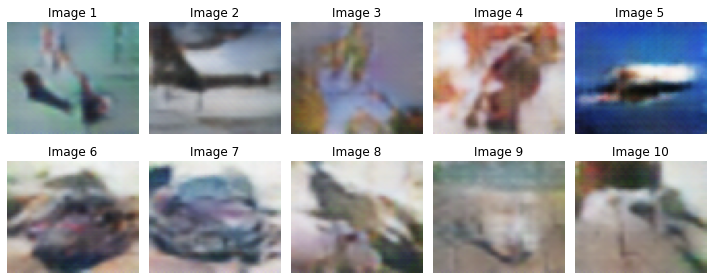

In [6]:
# Plot the 10 best generated images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, img in enumerate(best_images):
    ax = axes[i // 5, i % 5]
    img_np = img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Denormalize
    ax.imshow(img_np, aspect="auto")
    ax.set_title(f"Image {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [7]:
import os
from PIL import Image
from torchmetrics.image.fid import FrechetInceptionDistance

real_image_dir = "/home/jingjiw/Images/Real"
fake_image_dir = "/home/jingjiw/Images/Fake"

preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

def read_and_preprocess_image(img_path):
    img = Image.open(img_path)
    preprocessed_img = preprocess(img)
    return (preprocessed_img * 255).byte()


real_image_files = [f'real_image49_{i}.png' for i in range(80)]
fake_image_files = [f'fake_image49_{i}.png' for i in range(100)]

real_images = torch.stack([read_and_preprocess_image(os.path.join(real_image_dir, file)) for file in real_image_files])
fake_images = torch.stack([read_and_preprocess_image(os.path.join(fake_image_dir, file)) for file in fake_image_files])

fid = FrechetInceptionDistance()

fid.update(real_images, real=True)
fid.update(fake_images, real=False)

fid_score = fid.compute()
print("FID score:", fid_score)


FID score: tensor(249.5153)
